# Dog Breed Identifier

---

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

---

In this project, I've built a pipeline that can be used within a web or mobile app to process real-world, user-supplied images.  Given an image of a dog, the algorithm identifies an estimate of the dog's breed.  If supplied an image of a human, the algorithm identifies the most resembling dog breed.  

The image below displays a sample output:

![Sample Dog Output](images/sample_dog_output.png)

### Table of Content

Here are the different steps of the pipeline.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write the Final Algorithm
* [Step 6](#step6): Test the Algorithm on Sample Images

---

<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, I've imported a dataset of dog images:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

Using TensorFlow backend.


In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


Here are the 133 different possible dog breeds in the dataset

In [3]:
dog_names

['Affenpinscher',
 'Afghan_hound',
 'Airedale_terrier',
 'Akita',
 'Alaskan_malamute',
 'American_eskimo_dog',
 'American_foxhound',
 'American_staffordshire_terrier',
 'American_water_spaniel',
 'Anatolian_shepherd_dog',
 'Australian_cattle_dog',
 'Australian_shepherd',
 'Australian_terrier',
 'Basenji',
 'Basset_hound',
 'Beagle',
 'Bearded_collie',
 'Beauceron',
 'Bedlington_terrier',
 'Belgian_malinois',
 'Belgian_sheepdog',
 'Belgian_tervuren',
 'Bernese_mountain_dog',
 'Bichon_frise',
 'Black_and_tan_coonhound',
 'Black_russian_terrier',
 'Bloodhound',
 'Bluetick_coonhound',
 'Border_collie',
 'Border_terrier',
 'Borzoi',
 'Boston_terrier',
 'Bouvier_des_flandres',
 'Boxer',
 'Boykin_spaniel',
 'Briard',
 'Brittany',
 'Brussels_griffon',
 'Bull_terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn_terrier',
 'Canaan_dog',
 'Cane_corso',
 'Cardigan_welsh_corgi',
 'Cavalier_king_charles_spaniel',
 'Chesapeake_bay_retriever',
 'Chihuahua',
 'Chinese_crested',
 'Chinese_shar-pei',
 'Chow_cho

### Import Human Dataset

In the code cell below, I've imported a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


Here is the first human image file, for example:

In [4]:
human_files[0]

'lfw/Gene_Robinson/Gene_Robinson_0004.jpg'

---
<a id='step1'></a>
## Step 1: Detect Humans

I've used OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  I've downloaded one of these detectors and stored it in the `/haarcascades` directory.

In the next code cell, I demonstrate how to use this detector to find human faces in a sample image.

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline   

Number of faces detected: 3


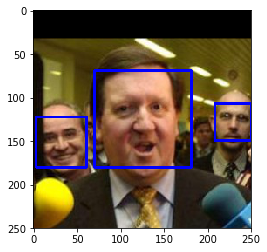

In [4]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

I've written a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

The code cell below tests the performance of the `face_detector` function. Of the first 100 images of humans, 99% got a human detected in them. Unfortunately, of the first 100 images of dogs, 11% got a human detected in them, which was not really the case. Some dogs are mistaken as humans. 

In [34]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_files_with_faces = 0
dog_files_with_faces = 0

for human_file in human_files_short:
        if face_detector(human_file):
            human_files_with_faces += 1
print('Percentage of human images with a detected human face:', human_files_with_faces/len(human_files_short))
            
for dog_file in dog_files_short:
        if face_detector(dog_file):
            dog_files_with_faces += 1     
print('Percentage of dog images with a detected human face:', dog_files_with_faces/len(dog_files_short))            

Percentage of human images with a detected human face: 0.99
Percentage of dog images with a detected human face: 0.11


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, I use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  The first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D tensor as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset!

In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm_notebook as tqdm

In [7]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of the [ImageNet-1000 label dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input_resnet50(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

In the [ImageNet-1000 label dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

The code cell below tests the performance of the `dog_detector` function. Of the first 100 images of humans, 0% got a dog detected in them. Of the first 100 images of dogs, 100% got a dog detected in them. The Dog Detector looks super accurate.

In [44]:
human_files_with_dogs = 0
dog_files_with_dogs = 0

for human_file in human_files_short:
        if dog_detector(human_file):
            human_files_with_dogs += 1
print('Percentage of human images with a detected dog:', human_files_with_dogs/len(human_files_short))
            
for dog_file in dog_files_short:
        if dog_detector(dog_file):
            dog_files_with_dogs += 1     
print('Percentage of dog images with a detected dog:', dog_files_with_dogs/len(dog_files_short))            

Percentage of human images with a detected dog: 0.0
Percentage of dog images with a detected dog: 1.0


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, I've created from scratch a CNN that classifies dog breeds.   

The task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Our vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

Setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [10]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

### Augment the Dog Dataset

Create and Configure Augmented Image Generator

In [10]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.2,  # randomly shift images horizontally (20% of total width)
    height_shift_range=0.2,  # randomly shift images vertically (20% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.2,  # randomly shift images horizontally (20% of total width)
    height_shift_range=0.2,  # randomly shift images vertically (20% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

Visualize Original and Augmented Images

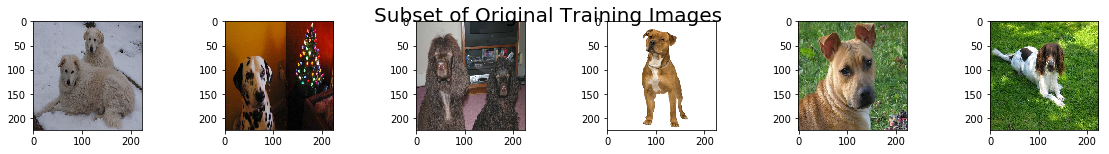

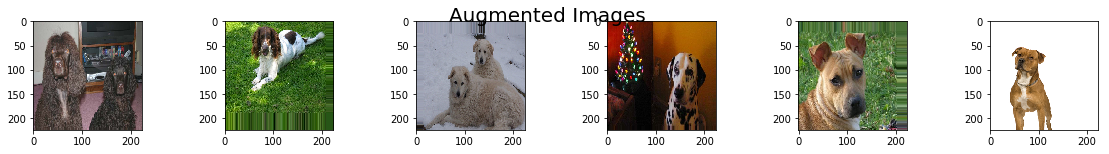

In [22]:
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = train_tensors[:6]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 6, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=6):
    for i in range(0, 6):
        ax = fig.add_subplot(1, 6, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

### Model Architecture
           
I chose basically the same architecture as in this lesson's example: https://github.com/udacity/aind2-cnn/blob/master/cifar10-classification/cifar10_cnn.ipynb. 

I changed the final layer's number of nodes from 10 in the CIFAR-10 lesson to 133 to get a prediction vector that corresponds to the number of possible dog breeds for this project. 

Since the tensors in this project are 224 x 224 x 3 rather than the 32 x 32 x 3 tensors from the lesson, it initially gave me around 25M parameters rather than the 500K parameters in the lesson. To reduce the number of parameters, I changed the pool size of the pooling layers from 2 to 3, which then gave me around 2M parameters. To reduce the number of parameters even more, I removed the `model.add(Dense(500, activation='relu'))` layer and ended up with around 500K parameters. 

I also like this CNN architecture because it includes 2 Dropout layers to avoid overfitting.

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

In [31]:
model = None
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 74, 74, 32)        2080      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 24, 24, 64)        8256      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8, 8, 64)          0         
__________

### Compile the Model

In [67]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Using model checkpointing saves the model that attains the best validation loss.

In [12]:
from keras.callbacks import ModelCheckpoint 

In [68]:
### Specify the number of epochs that you would like to use to train the model.

batch_size = 32
epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/10
208/208 [==============================] - 61s - loss: 4.8600 - acc: 0.0113 - val_loss: 4.7726 - val_acc: 0.0228
Epoch 2/10
208/208 [==============================] - 58s - loss: 4.6841 - acc: 0.0325 - val_loss: 4.6453 - val_acc: 0.0361
Epoch 3/10
208/208 [==============================] - 59s - loss: 4.5225 - acc: 0.0496 - val_loss: 4.5225 - val_acc: 0.0461
Epoch 4/10
208/208 [==============================] - 58s - loss: 4.3902 - acc: 0.0630 - val_loss: 4.4154 - val_acc: 0.0785
Epoch 5/10
208/208 [==============================] - 58s - loss: 4.2887 - acc: 0.0768 - val_loss: 4.3679 - val_acc: 0.0635
Epoch 6/10
208/208 [==============================] - 58s - loss: 4.2132 - acc: 0.0858 - val_loss: 4.3481 - val_acc: 0.0648
Epoch 7/10
208/208 [==============================] - 58s - loss: 4.1609 - acc: 0.0929 - val_loss: 4.2531 - val_acc: 0.0922
Epoch 8/10
208/208 [==============================] - 58s - loss: 4.0956 - acc: 0.1003 - val_loss: 4.1757 - val_acc: 0.0884
Epoch 9/

### Load the Model with the Best Validation Loss

In [32]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out the model on the test dataset of dog images.

In [33]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 10.0478%


This first CNN classifier gives a test accuracy of around 10%, which is more than 10 times better than random guessing, but is still very low. In the next step, I'll use transfer learning to train a CNN rather than building one from scratch.

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

I will now use transfer learning to create a CNN that can identify dog breed from images.

In [13]:
from keras.applications import VGG16, VGG19, ResNet50, InceptionV3, Xception

### Model Architecture

I chose basically the same architecture as in this lesson's example: https://github.com/udacity/aind2-cnn/blob/master/transfer-learning/transfer_learning.ipynb. 

Since the final layer of the convolutional base of complex CNN architectures like VGG16, InceptionV3 and Xception have a high number of filters, it's better to use a GlobalAveragePooling2D layer as the first layer of the classifier instead of flattening its last layer, to avoid having a too high number of parameters. 

I changed the final layer's number of nodes to 133 to get a prediction vector that corresponds to the number of possible dog breeds for this project. 

In [14]:
def build_classifier(train_cnn_architecture):
    classifier = None
    classifier = Sequential()
    classifier.add(GlobalAveragePooling2D(input_shape=train_cnn_architecture.shape[1:]))
    classifier.add(Dense(133, activation='softmax'))
    return classifier

For each architecture (VGG16, VGG19, ResNet50, InceptionV3, Xception), generate the corresponding bottleneck features, and save the best trained model for each architecture in the `saved_models/` folder in the repository. Then, test the best model of each architecture against the test set to select the one with the highest accuracy.

In [21]:
cnn_architectures = {'VGG16':VGG16, 'VGG19':VGG19, 'ResNet50':ResNet50, 'InceptionV3':InceptionV3, 'Xception':Xception}
test_accuracies = {}
for cnn_architecture_name, cnn_architecture_model in cnn_architectures.items():
    print('\n\n\n\n\n\n\n\n\n\nTesting for', cnn_architecture_name,'architecture...')
  
    # Obtain Bottleneck Features
    # Import the CNN architecture Model, with the Final Fully-Connected Layers Removed
    conv_base_cnn_architecture = cnn_architecture_model(weights='imagenet', include_top=False)
    # Feed-forward each train, valid and test 3D feature tensor through the convolution base of the VGG-16 model to get the bottleneck features
    print('Obtaining Bottleneck Features...')
    train_cnn_architecture = [conv_base_cnn_architecture.predict(np.expand_dims(train_tensor, axis=0)) for train_tensor in tqdm(train_tensors)]
    valid_cnn_architecture = [conv_base_cnn_architecture.predict(np.expand_dims(valid_tensor, axis=0)) for valid_tensor in tqdm(valid_tensors)]
    test_cnn_architecture = [conv_base_cnn_architecture.predict(np.expand_dims(test_tensor, axis=0)) for test_tensor in tqdm(test_tensors)]
    # Stack the 3D tensor of each sample to build the 4D tensor to input to the neural network# 
    train_cnn_architecture = np.vstack(train_cnn_architecture)
    valid_cnn_architecture = np.vstack(valid_cnn_architecture)
    test_cnn_architecture = np.vstack(test_cnn_architecture)
    
    # Build classifier architecture
    classifier_cnn_architecture = build_classifier(train_cnn_architecture)
    
    # Compile the model
    classifier_cnn_architecture.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    # Train the model
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.'+cnn_architecture_name+'.hdf5', 
                               verbose=1, save_best_only=True)
    classifier_cnn_architecture.fit(train_cnn_architecture, train_targets, 
          validation_data=(valid_cnn_architecture, valid_targets),
          epochs=5, batch_size=32, callbacks=[checkpointer], verbose=1)
    
    # Load the Model with the Best Validation Loss
    classifier_cnn_architecture.load_weights('saved_models/weights.best.'+cnn_architecture_name+'.hdf5')
    
    # Test model
    predictions_cnn_architecture = [np.argmax(classifier_cnn_architecture.predict(np.expand_dims(feature, axis=0))) for feature in test_cnn_architecture]
    test_accuracy = np.sum(np.array(predictions_cnn_architecture)==np.argmax(test_targets, axis=1))/len(predictions_cnn_architecture)
    print(cnn_architecture_name,'test accuracy:', round(test_accuracy,4))
    
    test_accuracies[cnn_architecture_name] = test_accuracy

test_accuracies


Testing for VGG16 architecture...
Obtaining Bottleneck Features...



Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 1s - loss: 4.7872 - acc: 0.0332 - val_loss: 4.5895 - val_acc: 0.0731
Epoch 2/5
6680/6680 [==============================] - 1s - loss: 4.4323 - acc: 0.1055 - val_loss: 4.3447 - val_acc: 0.1174
Epoch 3/5
6680/6680 [==============================] - 1s - loss: 4.1636 - acc: 0.1629 - val_loss: 4.1555 - val_acc: 0.1449
Epoch 4/5
6680/6680 [==============================] - 1s - loss: 3.9425 - acc: 0.2171 - val_loss: 3.9873 - val_acc: 0.1641
Epoch 5/5
6680/6680 [==============================] - 1s - loss: 3.7463 - acc: 0.2439 - val_loss: 3.8512 - val_acc: 0.2072
VGG16 test accuracy: 0.2237

Testing for VGG19 architecture...
Obtaining Bottleneck Features...



Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 1s - loss: 4.8074 - acc: 0.0316 - val_loss: 4.6589 - val_acc: 0.0491
Epoch 2/5
6680/6680 [==============================] - 1s - loss: 4.5152 - acc: 0.0814 - val_loss: 4.4499 - val_acc: 0.0994
Epoch 3/5
6680/6680 [==============================] - 1s - loss: 4.2899 - acc: 0.1319 - val_loss: 4.2800 - val_acc: 0.1353
Epoch 4/5
6680/6680 [==============================] - 1s - loss: 4.0955 - acc: 0.1722 - val_loss: 4.1267 - val_acc: 0.1569
Epoch 5/5
6680/6680 [==============================] - 1s - loss: 3.9254 - acc: 0.1991 - val_loss: 4.0087 - val_acc: 0.1689
VGG19 test accuracy: 0.1687

Testing for ResNet50 architecture...
Obtaining Bottleneck Features...



Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 1s - loss: 4.9786 - acc: 0.0123 - val_loss: 4.9033 - val_acc: 0.0120
Epoch 2/5
6680/6680 [==============================] - 0s - loss: 4.8954 - acc: 0.0180 - val_loss: 4.8942 - val_acc: 0.0204
Epoch 3/5
6680/6680 [==============================] - 0s - loss: 4.8532 - acc: 0.0201 - val_loss: 4.8532 - val_acc: 0.0144
Epoch 4/5
6680/6680 [==============================] - 0s - loss: 4.8182 - acc: 0.0229 - val_loss: 4.8109 - val_acc: 0.0251
Epoch 5/5
6680/6680 [==============================] - 0s - loss: 4.7904 - acc: 0.0275 - val_loss: 4.7991 - val_acc: 0.0275
ResNet50 test accuracy: 0.0311

Testing for InceptionV3 architecture...
Obtaining Bottleneck Features...



Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 3s - loss: 1.2528 - acc: 0.6936 - val_loss: 0.6150 - val_acc: 0.8072
Epoch 2/5
6680/6680 [==============================] - 2s - loss: 0.4849 - acc: 0.8506 - val_loss: 0.6087 - val_acc: 0.8335
Epoch 3/5
6680/6680 [==============================] - 2s - loss: 0.3545 - acc: 0.8900 - val_loss: 0.6102 - val_acc: 0.8431
Epoch 4/5
6680/6680 [==============================] - 2s - loss: 0.2751 - acc: 0.9096 - val_loss: 0.6236 - val_acc: 0.8491
Epoch 5/5
6680/6680 [==============================] - 2s - loss: 0.2144 - acc: 0.9296 - val_loss: 0.6322 - val_acc: 0.8467
InceptionV3 test accuracy: 0.7931

Testing for Xception architecture...
Obtaining Bottleneck Features...



Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 6s - loss: 1.1729 - acc: 0.7229 - val_loss: 0.5286 - val_acc: 0.8395
Epoch 2/5
6680/6680 [==============================] - 4s - loss: 0.4165 - acc: 0.8729 - val_loss: 0.4862 - val_acc: 0.8515
Epoch 3/5
6680/6680 [==============================] - 4s - loss: 0.3197 - acc: 0.8991 - val_loss: 0.4764 - val_acc: 0.8551
Epoch 4/5
6680/6680 [==============================] - 4s - loss: 0.2632 - acc: 0.9151 - val_loss: 0.4802 - val_acc: 0.8563
Epoch 5/5
6680/6680 [==============================] - 4s - loss: 0.2219 - acc: 0.9310 - val_loss: 0.4869 - val_acc: 0.8491
Xception test accuracy: 0.8517


{'InceptionV3': 0.7930622009569378,
 'ResNet50': 0.031100478468899521,
 'VGG16': 0.22368421052631579,
 'VGG19': 0.1686602870813397,
 'Xception': 0.85167464114832536}

After training on 5 epochs each CNN architecture, Xception has the highest accuracy on the test set, around 85%

In [15]:
classifier_Xception = Sequential()
classifier_Xception.add(GlobalAveragePooling2D(input_shape= (7, 7, 2048)))
classifier_Xception.add(Dense(133, activation='softmax'))

classifier_Xception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Load the Model with the Best Test Accuracy
classifier_Xception.load_weights('saved_models/weights.best.Xception.hdf5')

### Predict Dog Breed with the Model

This function takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by the model.  

In [17]:
from keras.applications.xception import Xception, preprocess_input as preprocess_input_xception

def Xception_predict_breed(img_path):
    # extract bottleneck features from original image by passing through Xception convolutional base
    tensor = path_to_tensor(img_path)
    bottleneck_feature = Xception(weights='imagenet', include_top=False).predict(preprocess_input_xception(tensor))
    # obtain predicted vector by passing bottleneck features through classifier
    predicted_vector = classifier_Xception.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

Test predicting the dog breed on a sample image

In [18]:
Xception_predict_breed('dogImages/test/096.Labrador_retriever/Labrador_retriever_06472.jpg')

'Labrador_retriever'

#### Test Dog Breed Classifier on 30 sample dog images

In [64]:
x_test = test_files[:30]
y_test = test_targets[:30]

y_hat = []
for img_path in x_test:
    prediction = Xception_predict_breed(img_path)
    y_hat.append(prediction)

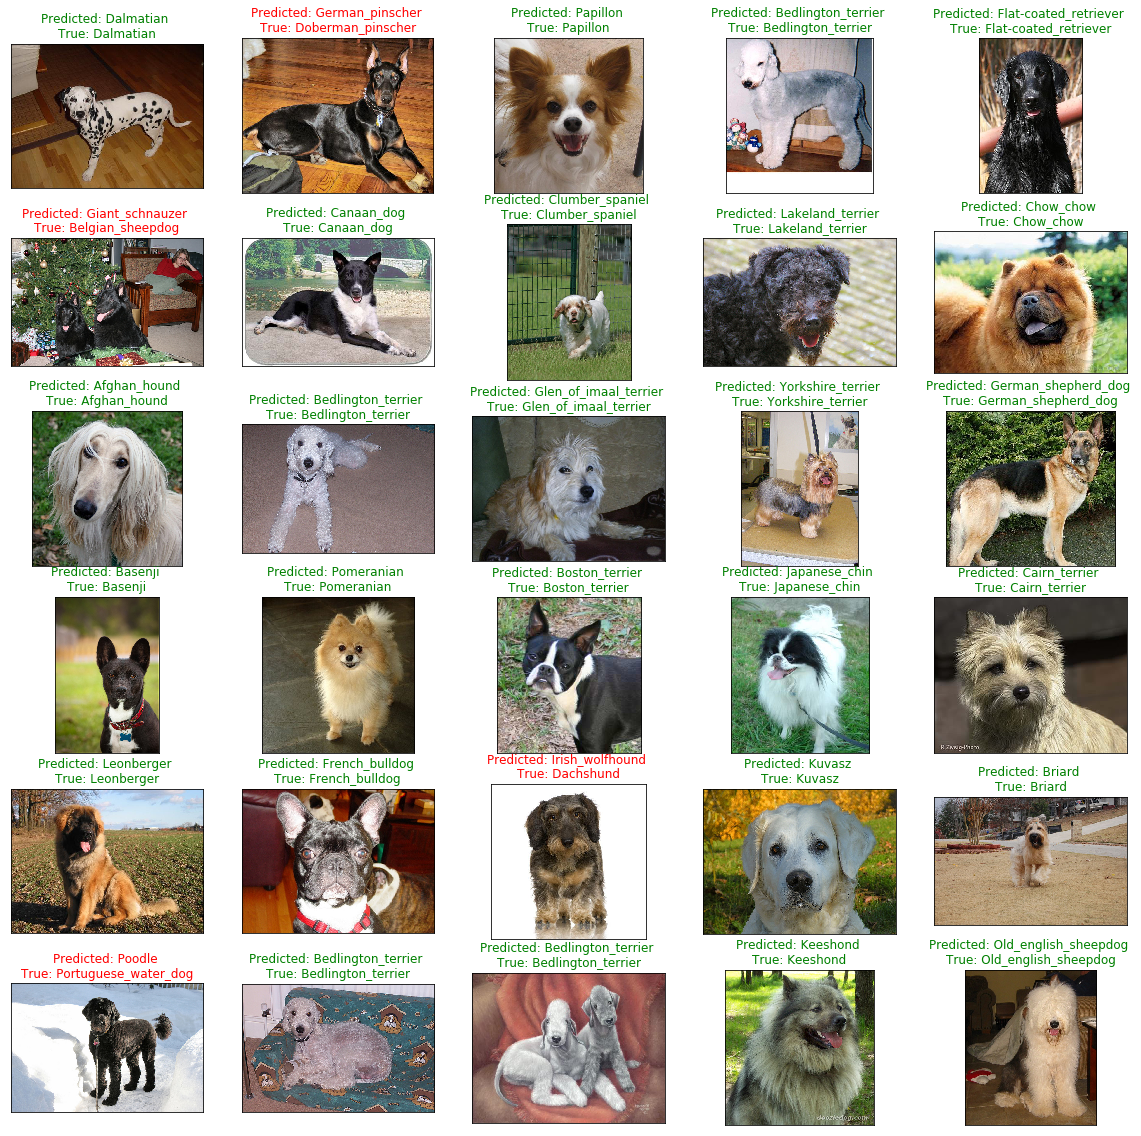

In [65]:
# plot test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 20))
for i, img_path in enumerate(x_test):
    ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
    x_img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(x_img, cv2.COLOR_BGR2RGB)
    plt.imshow(np.squeeze(cv_rgb))
    prediction = y_hat[i]
    true_idx = np.argmax(y_test[i])
    ax.set_title("Predicted: {} \nTrue: {}".format(prediction, dog_names[true_idx]),
                 color=("green" if prediction == dog_names[true_idx] else "red"))

The Xception CNN predicted correctly 26 out of the 30 sample dog images, which is pretty good considering there are 133 possible dog breeds in our model!

#### Test Dog Breed Classifier on 10 sample human images

In [55]:
x_test_humans = human_files[:10]

y_hat_humans = []
for img_path in x_test_humans:
    prediction = Xception_predict_breed(img_path)
    y_hat_humans.append(prediction)

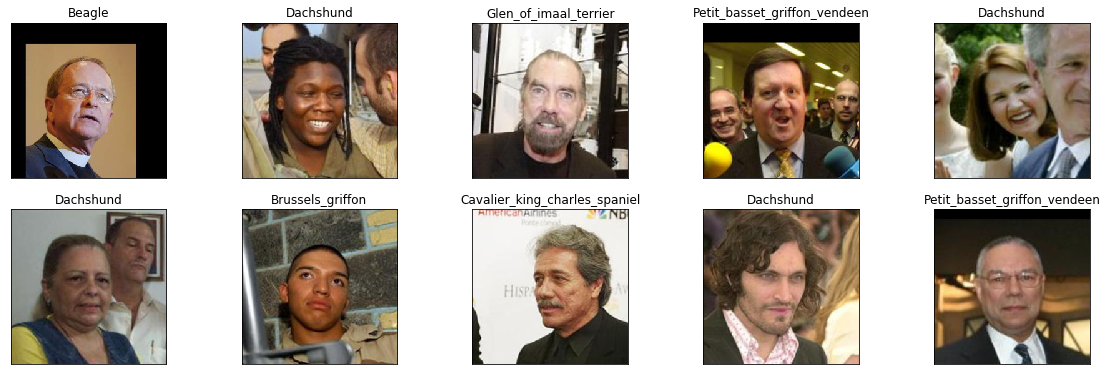

In [56]:
# plot test images, their predicted labels
fig = plt.figure(figsize=(20, 20))
for i, img_path in enumerate(x_test_humans):
    ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
    x_img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(x_img, cv2.COLOR_BGR2RGB)
    plt.imshow(np.squeeze(cv_rgb))
    prediction = y_hat_humans[i]
    ax.set_title(prediction)

---
<a id='step5'></a>
## Step 5: Write the Final Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

Here is a sample output of the algorithm:
![Sample Human Output](images/sample_human_output.png)

In [23]:
def dog_breed_identifier(img_path):
    isHuman = False
    isDog = False
    
    # Detect human or dog
    if dog_detector(img_path):
        isDog = True
        print('\n\n\n\n\nDog detected!')
    elif face_detector(img_path):
        isHuman = True
        print('\n\n\n\n\nHuman detected!')
    else:
        print('\n\n\n\n\nNo human or dog detected.')
        
    # Show image
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    # Identify dog breed
    predicted_breed = Xception_predict_breed(img_path)
    predicted_breed_split = predicted_breed.split('_')
    predicted_breed_formatted = ""
    for word in predicted_breed_split:
        predicted_breed_formatted += word + " "
    if isDog:
        print('Looks like a', predicted_breed_formatted)
    elif isHuman:
        print('You look like a', predicted_breed_formatted)

---
<a id='step6'></a>
## Step 6: Test the Algorithm on Sample Images

I've tested the algorithm on 5 dog images and 5 human images. 

For the dog images, it accurately detected a dog in all of them. I googled the predicted dog breed for each image and the Dog Breed Predictor seems to have guessed the dog breed accurately in all of them.

For the human images, it also accurately detected a human in all of them. I googled the predicted dog breed for each image and the Dog Breed Predictor seems to have guessed a similar-looking dog breed accurately in all of them.

#### Test algorithm on dog images






Dog detected!


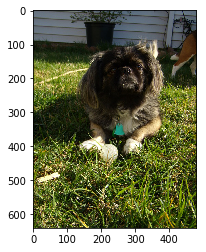

Looks like a Pekingese 





Dog detected!


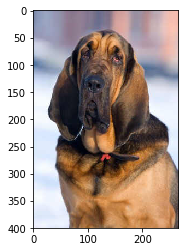

Looks like a Bloodhound 





Dog detected!


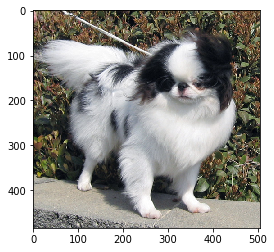

Looks like a Japanese chin 





Dog detected!


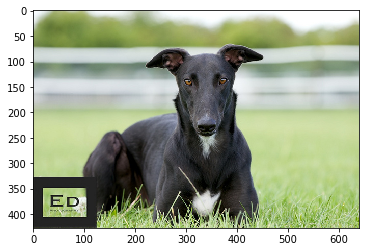

Looks like a Greyhound 





Dog detected!


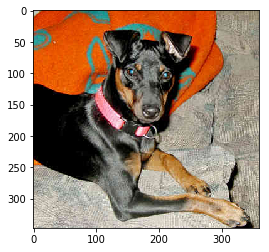

Looks like a German pinscher 


In [24]:
x_test_algo = test_files[-5:]
for img_path in x_test_algo:
    dog_breed_identifier(img_path)

#### Test algorithm on human images






Human detected!


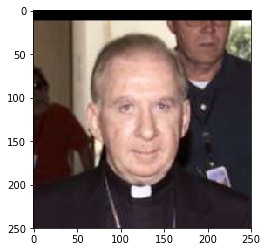

You look like a Dachshund 





Human detected!


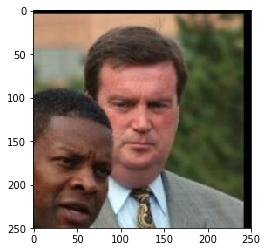

You look like a Cavalier king charles spaniel 





Human detected!


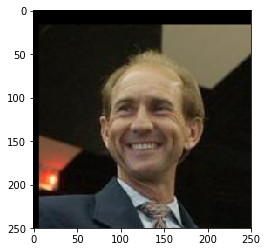

You look like a Glen of imaal terrier 





Human detected!


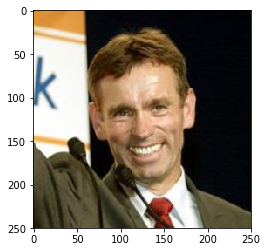

You look like a Dachshund 





Human detected!


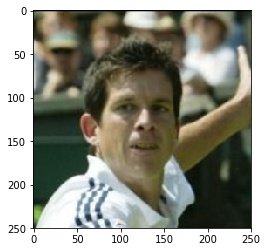

You look like a Smooth fox terrier 


In [25]:
x_test_humans_algo = human_files[-5:]
for img_path in x_test_humans_algo:
    dog_breed_identifier(img_path)

### Possible Future Improvements
- Our human detector detects human faces in around 10% of dog images, which is a high error rate. We could use a binary CNN classifier trained on human-face and non-human-face images to improve its accuracy.
- Using a CNN to detect human faces, we could also detect human faces viewed from the side if trained with such images
- Make the algorithm work in real time from a video feed rather than from an image file
- Use a CNN architecture with less parameters than Xception to increase speed, but train that model on more epochs to get similar test accuracy
- Implement the algorithm into a web app using [Flask](http://flask.pocoo.org/) or [web.py](http://webpy.org/docs/0.3/tutorial)!
- Overlay a Snapchat-like filter with dog ears on detected human heads.  Determine where to place the ears through the use of the OpenCV face detector, which returns a bounding box for the face.  To also overlay a dog nose filter, some nice tutorials for facial keypoints detection exist [here](https://www.kaggle.com/c/facial-keypoints-detection/details/deep-learning-tutorial).
- Currently, if a dog appears 51% German Shephard and 49% poodle, only the German Shephard breed is returned.  The algorithm is currently guaranteed to fail for every mixed breed dog.  Of course, if a dog is predicted as 99.5% Labrador, it is still worthwhile to round this to 100% and return a single breed.